In [24]:
import matplotlib
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import r2_score

In [25]:
df = pd.read_csv('data1011train.csv',encoding='UTF-8-Sig')
x = torch.tensor(df.iloc[:,[10,60,74,78,89,90,91,93,100,117,124,129,131,133,150,153,154,161,162,163,164,165,166,167,168]].to_numpy()).to(torch.float32)
y = torch.tensor(df.iloc[:,-1].to_numpy()).to(torch.float32)
x.shape

torch.Size([2950, 25])

In [26]:
class stockDataSetter(Dataset):
    def __init__(self, x, y=None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
            self.x = torch.FloatTensor(x)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]
    
    def __len__(self):
        return len(self.x)

In [27]:
Batchsize = (x.shape[0]//10)*4
train_set = stockDataSetter(x, y)
train_loader = DataLoader(train_set, Batchsize,shuffle=True, pin_memory=True)

In [28]:
import torch
import torch.nn.functional as F   

class My_model(torch.nn.Module): 
    def __init__(self, input_dim):
        super(My_model, self).__init__()
        self.layers = torch.nn.Sequential(
            nn.Linear(input_dim, 25),
            nn.ReLU(),
            nn.Linear(25, 1),
            )
        
    def forward(self, x):
        x = self.layers(x)
        x = x.squeeze(1)
        return x

net = My_model(input_dim=x.shape[1])
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# optimizer = torch.optim.RAdam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-5, weight_decay=0, foreach=True)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False, foreach=None, maximize=False, capturable=False)
loss_function = torch.nn.MSELoss(reduction='mean')

print(net)  # net 的结构

My_model(
  (layers): Sequential(
    (0): Linear(in_features=25, out_features=25, bias=True)
    (1): ReLU()
    (2): Linear(in_features=25, out_features=1, bias=True)
  )
)


In [29]:
#訓練
# checkpoint = torch.load('model_state_dict1.pt')
# net.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']
net = net.train()

best_loss = math.inf
patience_bestloss = 0

losslist = []
for t in range(1000000):
          
    x, y = next(iter(train_loader))
    prediction = net(x).to(device)
    loss = loss_function(prediction,y).to(device)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()


    # 接着上面来
    if t % 50 == 0:

        print('================================================')
        print(f'第:{t}輪', 'loss: ',loss.data.numpy())
        print(f'目前最佳loss: {best_loss}')
        print('patience_bestloss(最大1000): ',patience_bestloss )
        print('================================================')
    
    losslist.append(loss.data.numpy())
    if len(losslist)>50:
        losslist = losslist[1:]
    
    avgloss = sum(losslist)/len(losslist
                               )
    if avgloss<best_loss:
        patience_bestloss = 0
        best_loss = avgloss
        torch.save(net, 'Save_File2.pth')
        torch.save({
            'epoch': t,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, 'model_state_dict2.pt')

    else:
        patience_bestloss += 1
    
    if patience_bestloss >= 5000:
        print('loss已經訓練1000個batch未下降')
        break
    

第:0輪 loss:  2762349.8
目前最佳loss: inf
patience_bestloss(最大1000):  0
第:50輪 loss:  29533.29
目前最佳loss: 290587.762890625
patience_bestloss(最大1000):  0
第:100輪 loss:  22578.645
目前最佳loss: 24944.2702734375
patience_bestloss(最大1000):  0
第:150輪 loss:  21636.262
目前最佳loss: 22947.721171875
patience_bestloss(最大1000):  0
第:200輪 loss:  21256.64
目前最佳loss: 21678.54
patience_bestloss(最大1000):  6
第:250輪 loss:  20113.3
目前最佳loss: 20991.224921875
patience_bestloss(最大1000):  0
第:300輪 loss:  17592.354
目前最佳loss: 20061.0445703125
patience_bestloss(最大1000):  0
第:350輪 loss:  18994.336
目前最佳loss: 19569.36033203125
patience_bestloss(最大1000):  28
第:400輪 loss:  20247.428
目前最佳loss: 19164.0633203125
patience_bestloss(最大1000):  2
第:450輪 loss:  20135.775
目前最佳loss: 18807.79123046875
patience_bestloss(最大1000):  10
第:500輪 loss:  19702.477
目前最佳loss: 18495.443046875
patience_bestloss(最大1000):  4
第:550輪 loss:  17381.8
目前最佳loss: 18444.568984375
patience_bestloss(最大1000):  1
第:600輪 loss:  17013.121
目前最佳loss: 18253.41109375
patience_

In [30]:
#檢查
checkpoint = torch.load('model_state_dict2.pt')
net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
net = net.eval()

prediction = net(x).to(device)
loss = loss_function(prediction,y).to(device)

pred,actual = pd.DataFrame(prediction.data.numpy()), pd.DataFrame(y.data.numpy())
compare = pd.DataFrame(columns=['actual','predict'])
compare['actual'],compare['predict'] = y.data.numpy(), prediction.data.numpy()
compare = compare.T

loss:  12992.549


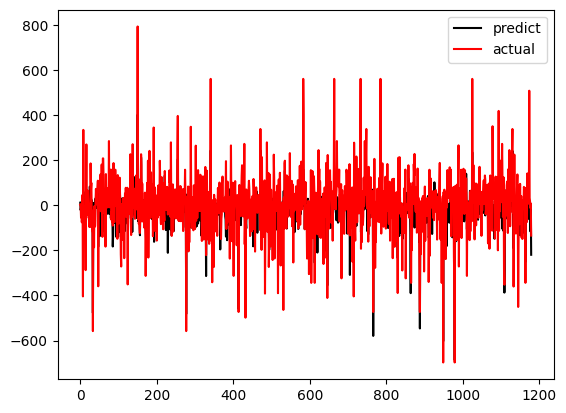

,0,1,2,3,4,5,6,7,8,9,...,1170,1171,1172,1173,1174,1175,1176,1177,1178,1179
actual,2.709961,4.970700,-54.650391,-5.629882,-75.689453,-42.600098,45.999512,-404.139648,333.839844,-62.660149,...,14.299810,6.560058,12.200200,34.180176,507.390625,32.320312,17.450199,-11.940430,7.90039,-134.648438
predict,11.351528,-21.844913,-10.126804,-3.546482,14.509914,-23.388279,-22.636906,-12.067905,59.878231,6.537259,...,-62.206089,-15.635105,-40.826389,5.629864,-56.170750,-1.529026,-35.443607,-115.985443,-4.16135,-219.626068


In [31]:
ax = plt.gca()
print('loss: ',loss.data.numpy())
compare.T.plot(kind='line',y ='predict',ax=ax,color='black')
compare.T.plot(kind='line',y ='actual',ax=ax,color='red')
plt.show()
compare
# Display all model layer weights
# for name, para in net.named_parameters():
#     print('{}: {}'.format(name, para.shape))

In [32]:
r2_score(compare.T['actual'],compare.T['predict'])

0.26763939888924804